In [1]:
import random
import pandas as pd
import numpy as np
from numpy import atleast_2d
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.cluster import KMeans
from sklearn.datasets.samples_generator import make_blobs
from sklearn import metrics
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.decomposition import TruncatedSVD 
from sklearn import random_projection
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_similarity_score
from sklearn.model_selection import cross_val_score
import seaborn as sns; sns.set()  # for plot styling
from mpl_toolkits.mplot3d import Axes3D
import math
from scipy.spatial.distance import cdist
import warnings
%matplotlib inline

In [25]:
cmap = cm.get_cmap('viridis')
pd.options.display.float_format = '{:,.2f}'.format

In [3]:
warnings.filterwarnings('ignore')

Load the Cancer data

In [4]:
cancer = pd.read_csv("cancer.csv", delimiter = ",")
cancer.drop(columns = ['ID'], inplace = True)
cancer[0:5]

,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
0,5,1,1,1,2,1,3,1,1,2
1,5,4,4,5,7,10,3,2,1,2
2,3,1,1,1,2,2,3,1,1,2
3,6,8,8,1,3,4,3,7,1,2
4,4,1,1,3,2,1,3,1,1,2


## Prepocessing Data Set

Column datatypes

In [5]:
print (cancer.dtypes)
print (cancer.shape)

Clump           int64
UnifSize        int64
UnifShape       int64
MargAdh         int64
SingEpiSize     int64
BareNuc        object
BlandChrom      int64
NormNucl        int64
Mit             int64
Class           int64
dtype: object
(699, 10)


We want the model to predict the value of Class (that is, benign (=2) or malignant (=4)). As this field can have one of only two possible values, we need to change its measurement level to reflect this.

In [6]:
#Change value 2 to 1 and 4 to 0
for i in range(0,699):
    if cancer.loc[i,'Class'] == 2:
        cancer.loc[i,'Class'] = 1
    else:
        cancer.loc[i,'Class'] = 0
    
    
#print (cancer.head(20))
#print (cancer.tail(20))

Remove non_numeric values for BareNuc column

In [7]:
cancer = cancer[pd.to_numeric(cancer['BareNuc'],errors ='coerrce').notnull()]
cancer['BareNuc'] = cancer['BareNuc'].astype('int')
print (cancer.dtypes)
print (cancer.shape)

Clump          int64
UnifSize       int64
UnifShape      int64
MargAdh        int64
SingEpiSize    int64
BareNuc        int64
BlandChrom     int64
NormNucl       int64
Mit            int64
Class          int64
dtype: object
(683, 10)


In [72]:
y = cancer['Class']
y[0:5]

0    1
1    1
2    1
3    1
4    1
Name: Class, dtype: int64

In [73]:
y.shape

(683,)

#### Normalizing over the standard deviation
Normalize the dataset using __StandardScaler()__ 

In [9]:
feature_df = cancer[['Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize', 'BareNuc', 'BlandChrom', 'NormNucl', 'Mit']]
X = np.asarray(feature_df)
M = StandardScaler().fit_transform(X)
M[0:5]

array([[ 0.19790469, -0.70221201, -0.74177362, -0.63936553, -0.5556085 ,
        -0.69885309, -0.18182716, -0.61292736, -0.34839971],
       [ 0.19790469,  0.27725185,  0.26278299,  0.75803177,  1.69516613,
         1.77286724, -0.18182716, -0.28510482, -0.34839971],
       [-0.51164337, -0.70221201, -0.74177362, -0.63936553, -0.5556085 ,
        -0.4242175 , -0.18182716, -0.61292736, -0.34839971],
       [ 0.55267873,  1.58320366,  1.6021918 , -0.63936553, -0.10545357,
         0.12505369, -0.18182716,  1.3540079 , -0.34839971],
       [-0.15686934, -0.70221201, -0.74177362,  0.05933312, -0.5556085 ,
        -0.69885309, -0.18182716, -0.61292736, -0.34839971]])

## kMeans Modeling

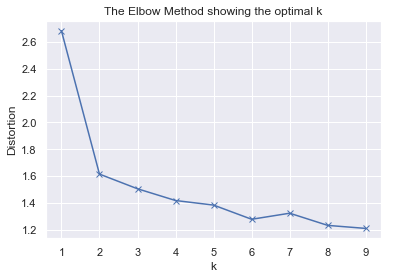

In [10]:
# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(M)
    kmeanModel.fit(M)
    distortions.append(sum(np.min(cdist(M, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / M.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [11]:
clusterNum = 2
k_means = KMeans(init = "random", n_clusters = clusterNum, n_init = 10)
k_means.fit(M)
labels = k_means.labels_
print(labels[0:5])

[0 1 0 1 0]


In [12]:
cluster_centers = k_means.cluster_centers_
inertia = k_means.inertia_
n_iter = k_means.n_iter_

print (cluster_centers)
print (inertia)
print (n_iter)

[[-0.49754639 -0.60923862 -0.60502382 -0.51828861 -0.51287856 -0.5891201
  -0.54885759 -0.53115265 -0.30760038]
 [ 0.97995006  1.19993519  1.19163388  1.02080322  1.01014777  1.16031046
   1.08101082  1.04613977  0.605839  ]]
2728.1495129753007
6


## Insights
Assign labels to each row in dataframe

In [13]:
cancer["Clus_km"] = labels
cancer.head(5)

,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class,Clus_km
0,5,1,1,1,2,1,3,1,1,1,0
1,5,4,4,5,7,10,3,2,1,1,1
2,3,1,1,1,2,2,3,1,1,1,0
3,6,8,8,1,3,4,3,7,1,1,1
4,4,1,1,3,2,1,3,1,1,1,0


We can easily check the centroid values by averaging the features in each cluster.

In [14]:
#cancer.drop(columns = ['Class'], inplace = True)
cancer.groupby('Clus_km').mean()

,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
Clus_km,,,,,,,,,,
0,3.04,1.28,1.41,1.35,2.09,1.40,2.10,1.25,1.07,0.96
1,7.20,6.83,6.77,5.75,5.48,7.77,6.09,6.06,2.65,0.04


Text(0.5, 1.0, 'K-Means Cluster Centers')

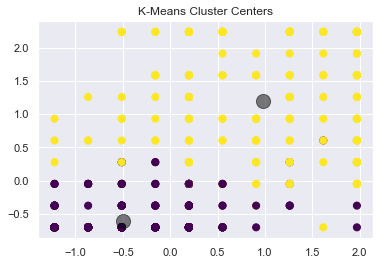

In [19]:
y_kmeans = k_means.predict(M)
plt.scatter(M[:, 0], M[:, 1], c=y_kmeans, s=50, cmap = 'viridis')

centers = k_means.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
plt.title('K-Means Cluster Centers')

Look at distribution based on Clump and BareNuc

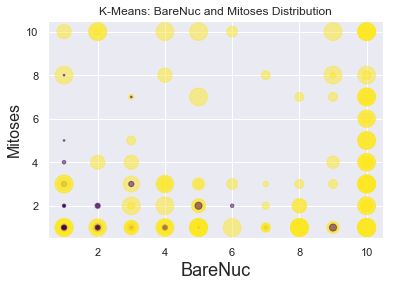

In [20]:
area = np.pi * ( X[:, 1])**2  
plt.scatter(X[:, 5], X[:, 8], s=area, c=labels.astype(np.float), alpha=0.5, cmap = 'viridis')
plt.xlabel('BareNuc', fontsize=18)
plt.ylabel('Mitoses', fontsize=16)
plt.title('K-Means: BareNuc and Mitoses Distribution')
plt.show()

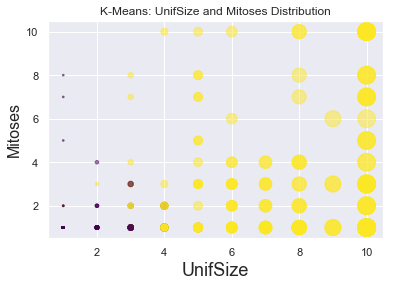

In [21]:
area = np.pi * ( X[:, 1])**2  
plt.scatter(X[:, 1], X[:, 8], s=area, c=labels.astype(np.float), alpha=0.5, cmap = 'viridis')
plt.xlabel('UnifSize', fontsize=18)
plt.ylabel('Mitoses', fontsize=16)
plt.title('K-Means: UnifSize and Mitoses Distribution')
plt.show()

Text(0.0, 1.0, '3-D K-Means')

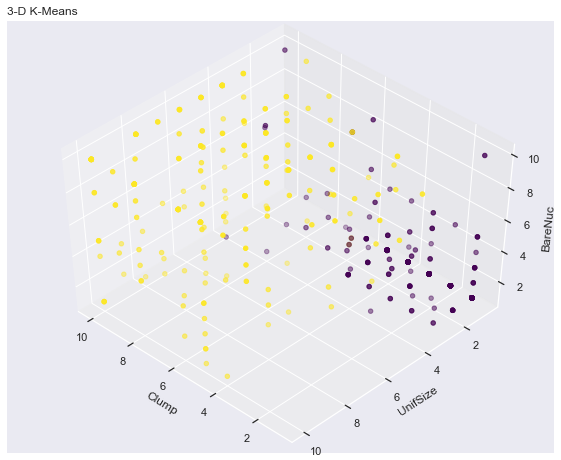

In [36]:
from mpl_toolkits.mplot3d import Axes3D 
fig = plt.figure(1, figsize=(8, 6))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()
# plt.ylabel('Age', fontsize=18)
# plt.xlabel('Income', fontsize=16)
# plt.zlabel('Education', fontsize=16)
ax.set_xlabel('Clump')
ax.set_ylabel('UnifSize')
ax.set_zlabel('BareNuc')

ax.scatter(X[:, 0], X[:, 1], X[:, 5], c= labels.astype(np.float), cmap = 'viridis')
plt.title("3-D K-Means", loc = "left")
#plt.legend()

k-means partitions data patients into mutually exclusive groups, for example, into 2 clusters. The patients in each cluster are similar to each other inifSize, BareNuc, and Clump thickness.
Now we can create a profile for each group, considering the common characteristics of each cluster. 
For example, the 2 clusters can be:

- Clump thickness < 6, InifSize < 4
- BareNuc > 4 and Clump > 4


## Expectation Maximization

In [28]:
np.random.seed(1)
gmm = GaussianMixture(n_components = 2)
gmm.fit(M)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=2, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [29]:
label_gmm = gmm.predict(M)

In [51]:
gmm.weights_

array([0.47624229, 0.52375771])

In [53]:
gmm.means_.T

array([[ 0.6181848 , -0.56210293],
       [ 0.72403443, -0.65834986],
       [ 0.71578054, -0.65084476],
       [ 0.62361434, -0.5670399 ],
       [ 0.64874372, -0.58988953],
       [ 0.76857873, -0.69885309],
       [ 0.66304136, -0.60289009],
       [ 0.65422694, -0.59487531],
       [ 0.38316008, -0.34839971]])

In [30]:
cancer['Clus_gmm'] = gmm.predict(M)
cancer.head(10)

,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class,Clus_km,Clus_gmm
0,5,1,1,1,2,1,3,1,1,1,0,1
1,5,4,4,5,7,10,3,2,1,1,1,0
2,3,1,1,1,2,2,3,1,1,1,0,0
3,6,8,8,1,3,4,3,7,1,1,1,0
4,4,1,1,3,2,1,3,1,1,1,0,1
5,8,10,10,8,7,10,9,7,1,0,1,0
6,1,1,1,1,2,10,3,1,1,1,0,0
7,2,1,2,1,2,1,3,1,1,1,0,1
8,2,1,1,1,2,1,1,1,5,1,0,0
9,4,2,1,1,2,1,2,1,1,1,0,1


In [31]:
#cancer['Label'] = y
#cancer.head(10)
cancer.groupby('Clus_gmm').mean()

,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class,Clus_km
Clus_gmm,,,,,,,,,,,
0,6.19,5.37,5.36,4.62,4.68,6.35,5.07,4.87,2.27,0.26,0.71
1,2.86,1.13,1.27,1.21,1.92,1.00,1.97,1.06,1.00,1.00,0.00


### Visualize GMM cluster

In [32]:
#cancer.drop(columns = ['Class'], inplace = True)
cancer.groupby('Clus_gmm').mean()

,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class,Clus_km
Clus_gmm,,,,,,,,,,,
0,6.19,5.37,5.36,4.62,4.68,6.35,5.07,4.87,2.27,0.26,0.71
1,2.86,1.13,1.27,1.21,1.92,1.00,1.97,1.06,1.00,1.00,0.00


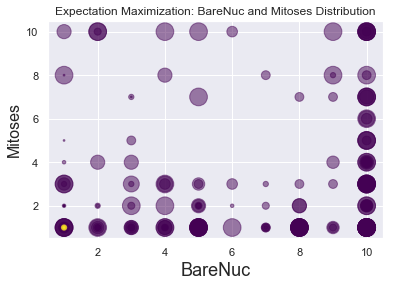

In [34]:
area = np.pi * ( X[:, 1])**2  
plt.scatter(X[:, 5], X[:, 8], s=area, c=label_gmm.astype(np.float), alpha=0.5, cmap = 'viridis')
plt.xlabel('BareNuc', fontsize=18)
plt.ylabel('Mitoses', fontsize=16)
plt.title('Expectation Maximization: BareNuc and Mitoses Distribution')
plt.show()

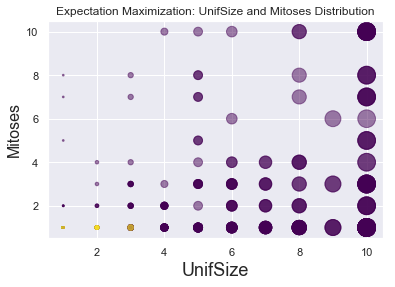

In [35]:
area = np.pi * ( X[:, 1])**2  
plt.scatter(X[:, 1], X[:, 8], s=area, c=label_gmm.astype(np.float), alpha=0.5, cmap = 'viridis')
plt.xlabel('UnifSize', fontsize=18)
plt.ylabel('Mitoses', fontsize=16)
plt.title('Expectation Maximization: UnifSize and Mitoses Distribution')
plt.show()

Text(0.0, 1.0, '3-D Expectation Maximization')

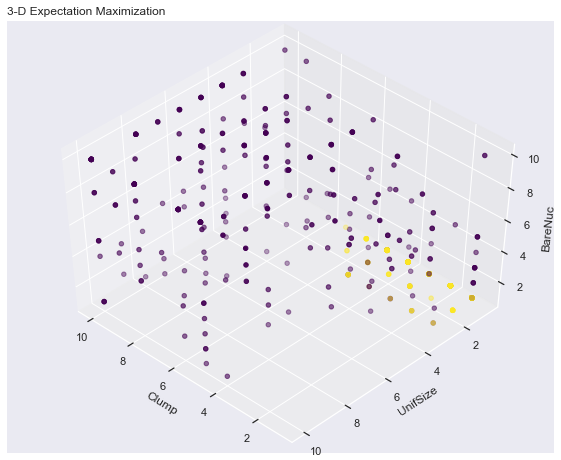

In [37]:
from mpl_toolkits.mplot3d import Axes3D 
fig = plt.figure(1, figsize=(8, 6))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()
# plt.ylabel('Age', fontsize=18)
# plt.xlabel('Income', fontsize=16)
# plt.zlabel('Education', fontsize=16)
ax.set_xlabel('Clump')
ax.set_ylabel('UnifSize')
ax.set_zlabel('BareNuc')
#CS = ax.contourf3D(X[:,0], X[:,1], X[:,5], cmap='RdBu_r', alpha=.5)
#CB = plt.colorbar(CS, shrink=0.8)

ax.scatter(X[:, 0], X[:, 1], X[:, 5], c= label_gmm.astype(np.float), cmap = 'viridis')
plt.title("3-D Expectation Maximization", loc = "left")

In [46]:
xmin, ymin = features_2D.min(axis=0)
xmax, ymax = features_2D.max(axis=0)

x = np.linspace(xmin, xmax, 500)
y = np.linspace(ymin, ymax, 500)
X, Y = np.meshgrid(x, y)

simulated_2D = np.column_stack([np.ravel(X), np.ravel(Y)])
simulated_4D = pca.inverse_transform(simulated_2D)
Z = atleast_2d(np.clip(np.exp(gmm.score_samples(simulated_4D)), a_min=0, a_max=1)).reshape(X.shape)

simulated_2D = np.column_stack([np.ravel(X), np.ravel(Y)])
simulated_4D = pca.inverse_transform(simulated_2D)
Z = atleast_2d(np.clip(np.exp(gmm.score_samples(simulated_4D)), a_min=0, a_max=1)).reshape(X.shape)

Text(0.5, 1.0, 'GMM Cluster Probabilities with PCA')

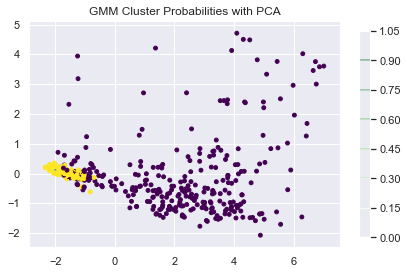

In [50]:

fig, ax = plt.subplots()
ax.set_aspect('equal')
CS = ax.contour(X, Y, Z, cmap='Greens', alpha=.5)
CB = plt.colorbar(CS, shrink=0.8)
ax.scatter(*features_2D.T, c=label_gmm.astype(np.float), s=15, cmap = 'viridis')
fig.tight_layout();
plt.title("GMM Cluster Probabilities with PCA")

## Dimensionality Reduction

### PCA

In [54]:
#Components equal to 9
pca = PCA()
features_2D = pca.fit_transform(M)

<function matplotlib.pyplot.show(*args, **kw)>

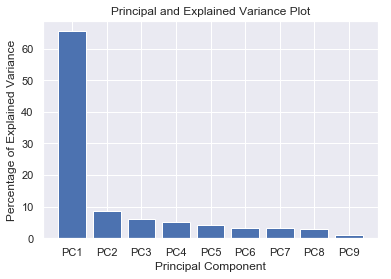

In [55]:
per_var = np.round(pca.explained_variance_ratio_*100, decimals=1)
labels = ['PC' + str(x) for x in range(1,len(per_var)+1)]
plt.bar(x=range(1,len(per_var)+1), height = per_var, tick_label = labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Principal and Explained Variance Plot')
plt.show


In [56]:
pca.explained_variance_ratio_

array([0.65549993, 0.08621632, 0.05991692, 0.05106972, 0.04225287,
       0.03354183, 0.03271141, 0.02897065, 0.00982036])

In [57]:
#Covariance Matrix 
df1 = pd.DataFrame(pca.components_,columns=['Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize', 'BareNuc', 'BlandChrom', 'NormNucl', 'Mit'],
                    index = ['PC-1','PC-2','PC-3','PC-4','PC-5','PC-6','PC-7','PC-8','PC-9'])

df1

,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit
PC-1,0.30,0.38,0.38,0.33,0.34,0.34,0.35,0.34,0.23
PC-2,-0.14,-0.05,-0.08,-0.05,0.16,-0.26,-0.23,0.03,0.91
PC-3,-0.87,0.02,-0.03,0.41,0.09,-0.00,0.21,0.13,-0.08
PC-4,-0.11,0.20,0.18,-0.49,0.43,-0.50,-0.01,0.42,-0.26
PC-5,-0.08,0.15,0.11,0.02,0.64,0.12,-0.23,-0.69,-0.11
PC-6,0.24,0.14,0.07,0.65,-0.07,-0.61,-0.30,-0.02,-0.15
PC-7,0.01,0.21,0.13,-0.12,-0.21,-0.40,0.70,-0.46,0.13
PC-8,0.25,-0.44,-0.58,0.16,0.46,-0.13,0.38,0.07,-0.05
PC-9,0.00,0.73,-0.67,-0.05,-0.07,0.08,-0.06,0.02,-0.01


In [75]:
#Components equal to 2
pca = PCA(n_components = 2)
features_2D = pca.fit_transform(M)

In [76]:
features_2D.shape

(683, 2)

<function matplotlib.pyplot.show(*args, **kw)>

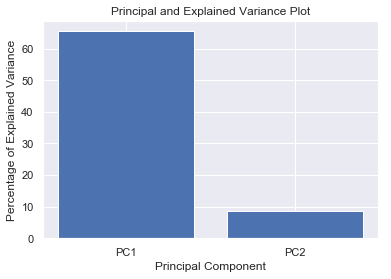

In [77]:
per_var = np.round(pca.explained_variance_ratio_*100, decimals=1)
labels = ['PC' + str(x) for x in range(1,len(per_var)+1)]
plt.bar(x=range(1,len(per_var)+1), height = per_var, tick_label = labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Principal and Explained Variance Plot')
plt.show


In [78]:
pca.explained_variance_ratio_

array([0.65549993, 0.08621632])

In [79]:
#Covariance Matrix
df2 = pd.DataFrame(pca.components_,columns=['Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize', 'BareNuc', 'BlandChrom', 'NormNucl', 'Mit'],index = ['PC-1','PC-2'])
df2

,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit
PC-1,0.30,0.38,0.38,0.33,0.34,0.34,0.35,0.34,0.23
PC-2,-0.14,-0.05,-0.08,-0.05,0.16,-0.26,-0.23,0.03,0.91


In [63]:
pca.components_.T


array([[ 0.30206257, -0.14080053],
       [ 0.38079297, -0.04664031],
       [ 0.37758254, -0.08242247],
       [ 0.33272357, -0.05209438],
       [ 0.33623404,  0.16440439],
       [ 0.33506751, -0.26126062],
       [ 0.34574737, -0.22807676],
       [ 0.33559138,  0.03396582],
       [ 0.2302064 ,  0.90555729]])

In [71]:
y.shape

(500,)

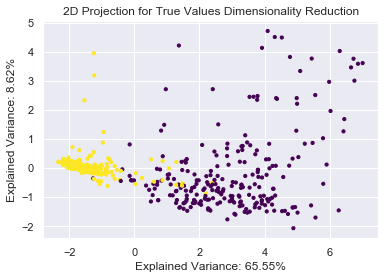

In [74]:
ev1, ev2 = pca.explained_variance_ratio_
ax = plt.figure().gca(title='2D Projection for True Values Dimensionality Reduction', 
                      xlabel='Explained Variance: {:.2%}'.format(ev1), 
                      ylabel='Explained Variance: {:.2%}'.format(ev2))
ax.scatter(*features_2D.T, c= y.astype(np.float), s=10, cmap = 'viridis');

In the above graph, the blue line represents component-wise explained variance while the orange line represents the cumulative explained variance. We are able to explain around 70% variance in the dataset using just two components. Let us now try to visualize each of these decomposed components:

The singular values corresponding to each of the selected components. The singular values are equal to the 2-norms of the n_components variables in the lower-dimensional space.

In [80]:
pca.singular_values_

array([63.4772247 , 23.02111471])

### ICA

In [81]:
ica = FastICA(n_components=3)
S_ = ica.fit_transform(M)

# For comparison, compute PCA
#pca = PCA(n_components=2)
#H = pca.fit_transform(M)  # Reconstruct signals based on orthogonal components

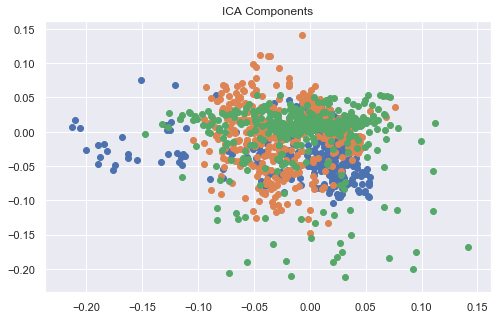

In [82]:
plt.figure(figsize=(8,5))
plt.title('ICA Components')
plt.scatter(S_[:,0], S_[:,1])
plt.scatter(S_[:,1], S_[:,2])
plt.scatter(S_[:,2], S_[:,0])

The data has been separated into different independent components which can be seen very clearly in the above image. X-axis and Y-axis represent the value of decomposed independent components.

### Singular Value Decomposition

We can also use Singular Value Decomposition (SVD) to decompose our original dataset into its constituents, resulting in dimensionality reduction. To learn the mathematics behind SVD, refer to this article.

SVD decomposes the original variables into three constituent matrices. It is essentially used to remove redundant features from the dataset. It uses the concept of Eigenvalues and Eigenvectors to determine those three matrices. We will not go into the mathematics of it due to the scope of this article, but let’s stick to our plan, i.e. reducing the dimensions in our dataset.

Let’s implement SVD and decompose our original variables:

In [83]:
svd = TruncatedSVD(n_components=3, random_state=42).fit_transform(M)

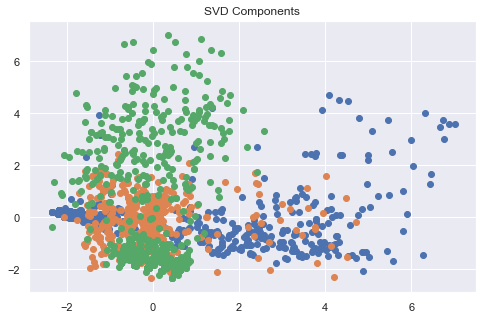

In [84]:
plt.figure(figsize=(8,5))
plt.title('SVD Components')
plt.scatter(svd[:,0], svd[:,1])
plt.scatter(svd[:,1], svd[:,2])
plt.scatter(svd[:,2],svd[:,0])

### Random Projection

In [85]:
from sklearn import manifold 
trans_data = manifold.Isomap(n_neighbors=5, n_components=3, n_jobs=-1).fit_transform(M)

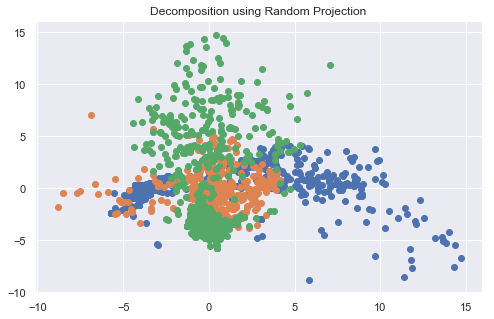

In [86]:
plt.figure(figsize=(8,5))
plt.title('Decomposition using Random Projection')
plt.scatter(trans_data[:,0], trans_data[:,1])
plt.scatter(trans_data[:,1], trans_data[:,2])
plt.scatter(trans_data[:,2], trans_data[:,0])

## Apply Clustering Algorithms to Dimensionality Reduction Data

### K-means Clustering with Dimensionality (PCA, ICA, Random, SVD)

In [87]:
pca = PCA(n_components=4)
A = pca.fit_transform(M)

In [88]:
clusterNum = 2
k_means = KMeans(init = "random", n_clusters = clusterNum, n_init = 10)
k_means.fit(A)
label_A = k_means.labels_
print(label_A[0:5])


[1 0 1 0 1]


Text(0.0, 1.0, '3-D K-Means with PCA Dimensionality Reduction')

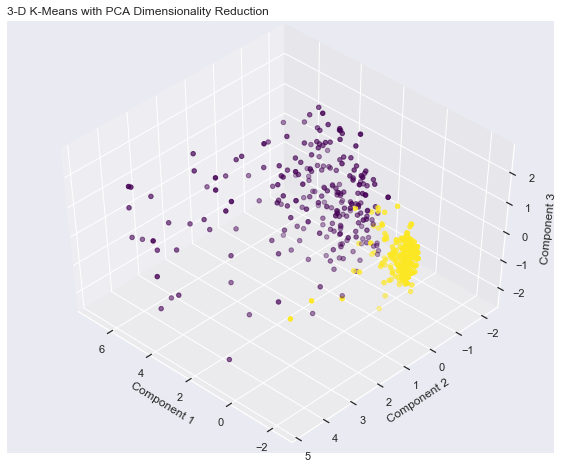

In [90]:
fig = plt.figure(1, figsize=(8, 6))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()
# plt.ylabel('Age', fontsize=18)
# plt.xlabel('Income', fontsize=16)
# plt.zlabel('Education', fontsize=16)
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')

ax.scatter(A[:, 0], A[:, 1], A[:, 2], c= label_A.astype(np.float), cmap = 'viridis')
plt.title("3-D K-Means with PCA Dimensionality Reduction", loc = "left")
#plt.legend()

In [91]:
ica = FastICA(n_components=4)
B = ica.fit_transform(M)


In [92]:
clusterNum = 2
k_meanB = KMeans(init = "random", n_clusters = clusterNum, n_init = 10)
k_meanB.fit(B)
label_B = k_meanB.labels_
print(label_B[0:5])

[1 0 1 0 1]


Text(0.0, 1.0, '3-D K-Means with ICA Dimensionality Reduction')

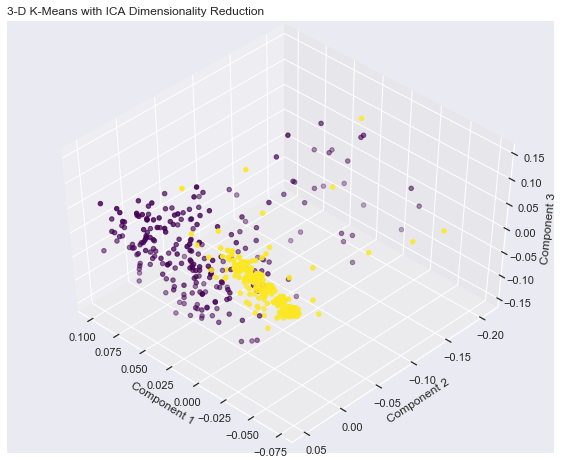

In [94]:
fig = plt.figure(1, figsize=(8, 6))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()
# plt.ylabel('Age', fontsize=18)
# plt.xlabel('Income', fontsize=16)
# plt.zlabel('Education', fontsize=16)
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')

ax.scatter(B[:, 0], B[:, 1], B[:, 2], c= label_B.astype(np.float), cmap = 'viridis')
plt.title("3-D K-Means with ICA Dimensionality Reduction", loc = "left")
#plt.legend()

In [95]:
clusterNum = 2
k_meanC = KMeans(init = "random", n_clusters = clusterNum, n_init = 10)
k_meanC.fit(svd)
label_C = k_meanC.labels_
print(label_C[0:5])

[0 1 0 1 0]


Text(0.0, 1.0, '3-D K-Means with SVD Dimensionality Reduction')

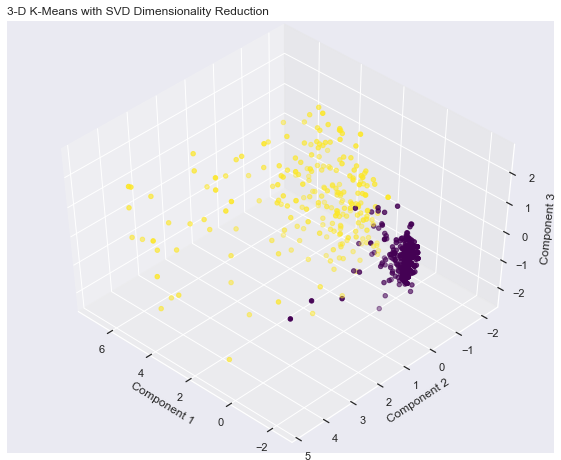

In [97]:
fig = plt.figure(1, figsize=(8, 6))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()
# plt.ylabel('Age', fontsize=18)
# plt.xlabel('Income', fontsize=16)
# plt.zlabel('Education', fontsize=16)
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')

ax.scatter(svd[:, 0], svd[:, 1], svd[:, 2], c= label_C.astype(np.float), cmap = 'viridis')
plt.title("3-D K-Means with SVD Dimensionality Reduction", loc = "left")
#plt.legend()

In [98]:
clusterNum = 2
k_meanD = KMeans(init = "random", n_clusters = clusterNum, n_init = 10)
k_meanD.fit(trans_data)
label_D = k_meanD.labels_
print(label_D[0:5])

[1 0 1 0 1]


Text(0.0, 1.0, '3-D K-Means with Random Projection Dimensionality Reduction')

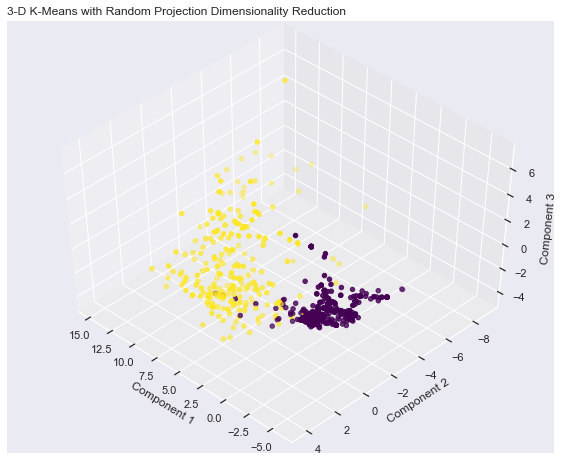

In [100]:
fig = plt.figure(1, figsize=(8, 6))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()
# plt.ylabel('Age', fontsize=18)
# plt.xlabel('Income', fontsize=16)
# plt.zlabel('Education', fontsize=16)
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')

ax.scatter(trans_data[:, 0], trans_data[:, 1], trans_data[:, 2], c= label_C.astype(np.float), cmap = 'viridis')
plt.title("3-D K-Means with Random Projection Dimensionality Reduction", loc = "left")
#plt.legend()

### Expectation Maximization with Dimesionality (PCA, ICA, Random Project, SVD)

In [101]:
gmm = GaussianMixture(n_components = 2)
gmm.fit(A)
labelA_gmm = gmm.predict(A)

In [102]:
labelA_gmm[0:5]

array([0, 1, 0, 1, 0])

Text(0.0, 1.0, '3-D Expectation Maximization with PCA Dimensionality Reduction')

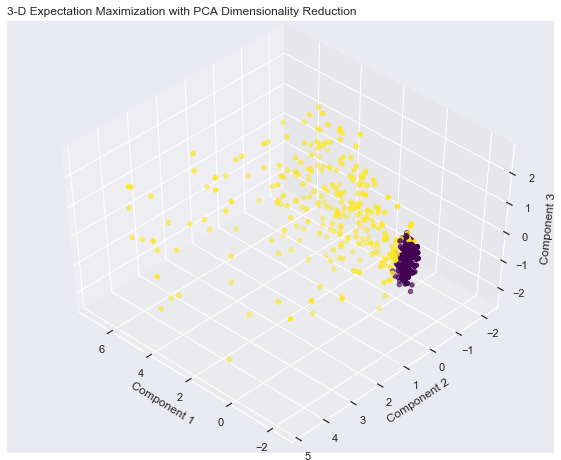

In [104]:
fig = plt.figure(1, figsize=(8, 6))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()
# plt.ylabel('Age', fontsize=18)
# plt.xlabel('Income', fontsize=16)
# plt.zlabel('Education', fontsize=16)
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')

ax.scatter(A[:, 0], A[:, 1], A[:, 2], c= labelA_gmm.astype(np.float), cmap = 'viridis')
plt.title("3-D Expectation Maximization with PCA Dimensionality Reduction", loc = "left")
#plt.legend()

In [105]:
gmm = GaussianMixture(n_components = 2)
gmm.fit(B)
labelB_gmm = gmm.predict(B)

In [106]:
labelB_gmm[0:5]

array([0, 1, 0, 1, 0])

Text(0.0, 1.0, '3-D Expectation Maximization with ICA Dimensionality Reduction')

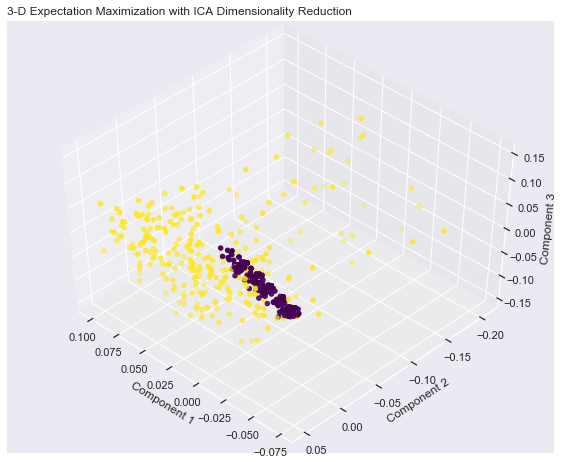

In [108]:
fig = plt.figure(1, figsize=(8, 6))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()
# plt.ylabel('Age', fontsize=18)
# plt.xlabel('Income', fontsize=16)
# plt.zlabel('Education', fontsize=16)
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')

ax.scatter(B[:, 0], B[:, 1], B[:, 2], c= labelB_gmm.astype(np.float), cmap = 'viridis')
plt.title("3-D Expectation Maximization with ICA Dimensionality Reduction", loc = "left")
#plt.legend()

In [109]:
gmm = GaussianMixture(n_components = 2)
gmm.fit(svd)
labelsvd_gmm = gmm.predict(svd)

In [110]:
labelsvd_gmm[0:5]

array([1, 0, 1, 0, 1])

Text(0.0, 1.0, '3-D Expectation Maximization with SVD Dimensionality Reduction')

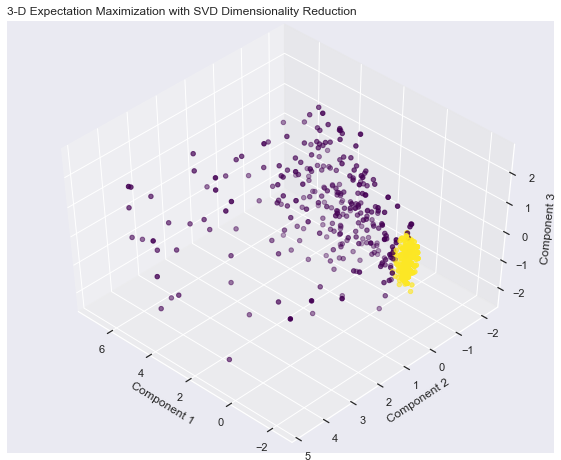

In [112]:
fig = plt.figure(1, figsize=(8, 6))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()
# plt.ylabel('Age', fontsize=18)
# plt.xlabel('Income', fontsize=16)
# plt.zlabel('Education', fontsize=16)
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')

ax.scatter(svd[:, 0], svd[:, 1], svd[:, 2], c= labelsvd_gmm.astype(np.float), cmap = 'viridis')
plt.title("3-D Expectation Maximization with SVD Dimensionality Reduction", loc = "left")
#plt.legend()

In [113]:
gmm = GaussianMixture(n_components = 2)
gmm.fit(trans_data)
labelD_gmm = gmm.predict(trans_data)

In [114]:
labelD_gmm[0:5]

array([1, 0, 1, 0, 1])

Text(0.0, 1.0, '3-D Expectation Maximization with Random Projection Dimensionality Reduction')

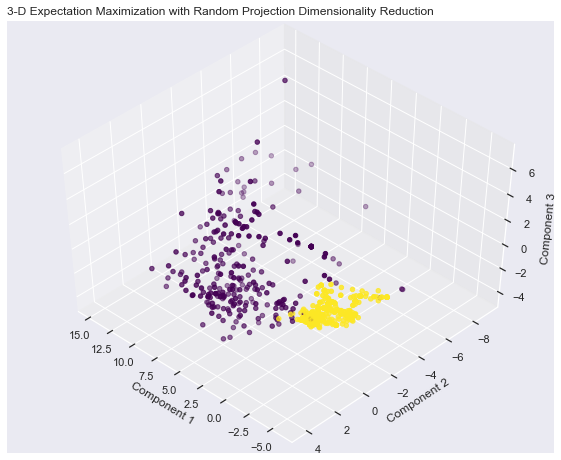

In [115]:
fig = plt.figure(1, figsize=(8, 6))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()
# plt.ylabel('Age', fontsize=18)
# plt.xlabel('Income', fontsize=16)
# plt.zlabel('Education', fontsize=16)
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')

ax.scatter(trans_data[:, 0], trans_data[:, 1], trans_data[:, 2], c= labelD_gmm.astype(np.float), cmap = 'viridis')
plt.title("3-D Expectation Maximization with Random Projection Dimensionality Reduction", loc = "left")
#plt.legend()

### Apply Neural Networks to Dimesionality Reduction Data

In [116]:
X_train, X_test, y_train, y_test = train_test_split(A, y, test_size=0.3, random_state=3)

mlp = MLPClassifier(hidden_layer_sizes=(9,9),max_iter=500, solver='lbfgs')
mlp.fit(X_train,y_train)
predictions = mlp.predict(X_test)
print(classification_report(y_test,predictions))
print("Neural Network (PCA) Accuracy: ", metrics.accuracy_score(y_test, predictions))

              precision    recall  f1-score   support

           0       0.97      0.88      0.93        77
           1       0.93      0.98      0.96       128

   micro avg       0.95      0.95      0.95       205
   macro avg       0.95      0.93      0.94       205
weighted avg       0.95      0.95      0.95       205

Neural Network (PCA) Accuracy:  0.9463414634146341


In [117]:
B_train, B_test, b_train, b_test = train_test_split(B, y, test_size=0.3, random_state=3)

mlpB = MLPClassifier(hidden_layer_sizes=(9,9),max_iter=500, solver='lbfgs')
mlpB.fit(B_train,b_train)
predictionsB = mlpB.predict(B_test)
print(classification_report(b_test,predictionsB))
print("Neural Network (ICA) Accuracy: ", metrics.accuracy_score(b_test, predictionsB))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95        77
           1       0.98      0.97      0.97       128

   micro avg       0.97      0.97      0.97       205
   macro avg       0.96      0.96      0.96       205
weighted avg       0.97      0.97      0.97       205

Neural Network (ICA) Accuracy:  0.9658536585365853


In [118]:
S_train, S_test, s_train, s_test = train_test_split(svd, y, test_size=0.3, random_state=3)

mlpS = MLPClassifier(hidden_layer_sizes=(9,9),max_iter=500, solver='lbfgs')
mlpS.fit(S_train,s_train)
predictionsS = mlpS.predict(S_test)
print(classification_report(s_test,predictionsS))
print("Neural Network (SVD) Accuracy: ", metrics.accuracy_score(s_test, predictionsS))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95        77
           1       0.97      0.97      0.97       128

   micro avg       0.96      0.96      0.96       205
   macro avg       0.96      0.96      0.96       205
weighted avg       0.96      0.96      0.96       205

Neural Network (SVD) Accuracy:  0.9609756097560975


In [119]:
T_train, T_test, t_train, t_test = train_test_split(trans_data, y, test_size=0.3, random_state=3)

mlpT = MLPClassifier(hidden_layer_sizes=(9,9),max_iter=500, solver='lbfgs')
mlpT.fit(T_train,t_train)
predictionsT = mlpT.predict(T_test)
print(classification_report(t_test,predictionsT))
print("Neural Network (Random Projection) Accuracy: ", metrics.accuracy_score(t_test, predictionsT))

              precision    recall  f1-score   support

           0       0.96      0.92      0.94        77
           1       0.95      0.98      0.97       128

   micro avg       0.96      0.96      0.96       205
   macro avg       0.96      0.95      0.95       205
weighted avg       0.96      0.96      0.96       205

Neural Network (Random Projection) Accuracy:  0.9560975609756097


### Using Clustering Data for Neural Networks

In [120]:
cancer.head(5)

,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class,Clus_km,Clus_gmm
0,5,1,1,1,2,1,3,1,1,1,0,1
1,5,4,4,5,7,10,3,2,1,1,1,0
2,3,1,1,1,2,2,3,1,1,1,0,0
3,6,8,8,1,3,4,3,7,1,1,1,0
4,4,1,1,3,2,1,3,1,1,1,0,1


In [121]:
cancer.drop(columns = ['Class'], inplace = True)

In [122]:
cancer.head(5)

,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Clus_km,Clus_gmm
0,5,1,1,1,2,1,3,1,1,0,1
1,5,4,4,5,7,10,3,2,1,1,0
2,3,1,1,1,2,2,3,1,1,0,0
3,6,8,8,1,3,4,3,7,1,1,0
4,4,1,1,3,2,1,3,1,1,0,1


Use label features "Class_km" and "Clus_gmm" for dataset and standardized dataset

In [123]:
feature_nn = cancer[['Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize', 'BareNuc', 'BlandChrom', 'NormNucl', 'Mit','Clus_km', 'Clus_gmm']]
J = np.asarray(feature_nn)
K = StandardScaler().fit_transform(J)
K[0:5]

array([[ 0.19790469, -0.70221201, -0.74177362, -0.63936553, -0.5556085 ,
        -0.69885309, -0.18182716, -0.61292736, -0.34839971, -0.71254913,
         0.95279653],
       [ 0.19790469,  0.27725185,  0.26278299,  0.75803177,  1.69516613,
         1.77286724, -0.18182716, -0.28510482, -0.34839971,  1.40341199,
        -1.04954202],
       [-0.51164337, -0.70221201, -0.74177362, -0.63936553, -0.5556085 ,
        -0.4242175 , -0.18182716, -0.61292736, -0.34839971, -0.71254913,
        -1.04954202],
       [ 0.55267873,  1.58320366,  1.6021918 , -0.63936553, -0.10545357,
         0.12505369, -0.18182716,  1.3540079 , -0.34839971,  1.40341199,
        -1.04954202],
       [-0.15686934, -0.70221201, -0.74177362,  0.05933312, -0.5556085 ,
        -0.69885309, -0.18182716, -0.61292736, -0.34839971, -0.71254913,
         0.95279653]])

In [124]:
K_train, K_test, k_train, k_test = train_test_split(K, y, test_size=0.3, random_state=3)

mlpK = MLPClassifier(hidden_layer_sizes=(9,9),max_iter=500, solver='lbfgs')
mlpK.fit(K_train,k_train)
predictionsK = mlpK.predict(K_test)
print(classification_report(k_test,predictionsK))
print("Neural Network (K-Means and Expectation Maximization) Accuracy: ", metrics.accuracy_score(k_test, predictionsK))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95        77
           1       0.97      0.97      0.97       128

   micro avg       0.96      0.96      0.96       205
   macro avg       0.96      0.96      0.96       205
weighted avg       0.96      0.96      0.96       205

Neural Network (K-Means and Expectation Maximization) Accuracy:  0.9609756097560975
